<a href="https://colab.research.google.com/github/sio-co2o2/scrippsco2_notebooks/blob/main/notebooks/plot_global_c14_stations_scrippsco2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/sio-co2o2/scrippsco2_notebooks/main?labpath=notebooks%2Fplot_global_c14_stations_scrippsco2.ipynb)

# Plot Isotopic C14 concentration trends from global stations 

### Scripps CO2 Program
https://scrippsco2.ucsd.edu

This notebook creates pdf and png plot versions.

## Import packages

In [32]:
import re
import pandas as pd
import numpy as np
import requests
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
import os
from PIL import Image

%matplotlib inline

In [33]:
# This package is used to convert a vector svg into a png

try:
  from cairosvg import svg2png
except:
  ! pip install cairosvg
  from cairosvg import svg2png

In [34]:
# This import is to enable Google Colab to save files ane then download them

# This import does not exist unless the notebook is run in Google Colab
# Put in a try except block if user wants to use notebook off of Google Colab

try:
    from google.colab import files
except:
    pass

## Set directories and file names for data,  plot, and logo

In [35]:
# Data from scrippsco2.ucsd.edu
isotope_data_dir = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/flask_isotopic/intermittent'

# Data from bluemoon
# isotope_data_dir = 'data/to_post/flask_isotopic/intermittent'

# Place in order want to plot  from bottom to top
stations = ['spo', 'psa', 'sam', 'kum',  'mlo', 'ljo', 'ptb']

station_urls = {}

monthly_ptb_file = 'intermittent_flask_c14_ptb.csv'
station_urls['ptb'] = f"{isotope_data_dir}/{monthly_ptb_file}"

monthly_ljo_file = 'intermittent_flask_c14_ljo.csv'
station_urls['ljo'] = f"{isotope_data_dir}/{monthly_ljo_file}"

monthly_mlo_file = 'intermittent_flask_c14_mlo.csv'
station_urls['mlo'] = f"{isotope_data_dir}/{monthly_mlo_file}"

monthly_kum_file = 'intermittent_flask_c14_kum.csv'
station_urls['kum'] = f"{isotope_data_dir}/{monthly_kum_file}"

monthly_sam_file = 'intermittent_flask_c14_sam.csv'
station_urls['sam'] = f"{isotope_data_dir}/{monthly_sam_file}"

monthly_psa_file = 'intermittent_flask_c14_psa.csv'
station_urls['psa'] = f"{isotope_data_dir}/{monthly_psa_file}"

monthly_spo_file = 'intermittent_flask_c14_spo.csv'
station_urls['spo'] = f"{isotope_data_dir}/{monthly_spo_file}"

# Set plot directories for website graphics gallery
plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

plot_pdf_dir = pathlib.Path(plot_dir / 'pdf')
plot_pdf_dir.mkdir(exist_ok=True)

plot_png_dir = pathlib.Path(plot_dir / 'png')
plot_png_dir.mkdir(exist_ok=True)

plot_display_dir = pathlib.Path(plot_dir / 'display')
plot_display_dir.mkdir(exist_ok=True)

plot_thumbnail_dir = pathlib.Path(plot_dir / 'thumbnails')
plot_thumbnail_dir.mkdir(exist_ok=True)

# logo_file = 'images/ucsd_sio_logo.svg'

logo_file = 'https://github.com/sio-co2o2/keelingcurve_notebooks/raw/main/images/logos/ucsd_sio_logo.svg'

plot_name = 'c14_sta_records_all_sta'

pdf_file = plot_pdf_dir / f'{plot_name}.pdf'
png_file = plot_png_dir / f'{plot_name}.png'
png_display_file = plot_display_dir / f'{plot_name}.png'
png_thumbnail_file = plot_thumbnail_dir / f'{plot_name}.png'


#### Get spline data for each station currently in a separate file

In [36]:
# Place in order want to plot  from bottom to top
spline_stations = ['spo', 'psa', 'sam', 'kum',  'mlo', 'ljo', 'ptb1', 'ptb2']

station_spline_urls = {}

# PTB data has a gap so there are two spline files
monthly_ptb1_file = 'intermittent_flask_c14_spline_ptb1.csv'
station_spline_urls['ptb1'] = f"{isotope_data_dir}/{monthly_ptb1_file}"

monthly_ptb2_file = 'intermittent_flask_c14_spline_ptb2.csv'
station_spline_urls['ptb2'] = f"{isotope_data_dir}/{monthly_ptb2_file}"

monthly_ljo_file = 'intermittent_flask_c14_spline_ljo.csv'
station_spline_urls['ljo'] = f"{isotope_data_dir}/{monthly_ljo_file}"

monthly_mlo_file = 'intermittent_flask_c14_spline_mlo.csv'
station_spline_urls['mlo'] = f"{isotope_data_dir}/{monthly_mlo_file}"

monthly_kum_file = 'intermittent_flask_c14_spline_kum.csv'
station_spline_urls['kum'] = f"{isotope_data_dir}/{monthly_kum_file}"

monthly_sam_file = 'intermittent_flask_c14_spline_sam.csv'
station_spline_urls['sam'] = f"{isotope_data_dir}/{monthly_sam_file}"

monthly_psa_file = 'intermittent_flask_c14_spline_psa.csv'
station_spline_urls['psa'] = f"{isotope_data_dir}/{monthly_psa_file}"

monthly_spo_file = 'intermittent_flask_c14_spline_spo.csv'
station_spline_urls['spo'] = f"{isotope_data_dir}/{monthly_spo_file}"

## Load in Data and process

#### Look at the file comments to see what the columns represent (same for all stations)

In [37]:
# Currently there are no comments but there will be

mlo_url = station_urls['mlo']

# Load from URL
response = requests.get(mlo_url)
file_text = response.text
text_lines = file_text.split('\n')

# Load from file
# with open(mlo_url) as f:
#     text_lines = f.readlines()

# From looking at the file, the column description comments start with
# the words 'The data file below'
comments = [line for line in text_lines if line.startswith('"')]

search_str = 'The data file below'
desc_line_start = [index for index, comment in enumerate(comments) if search_str in comment]

if desc_line_start:
    col_desc = comments[desc_line_start[0]:]
    print('\n'.join(col_desc))

print(comments)

[]


### Load in station data

In [38]:
station_dfs =  {}

for station in stations:
    data_url = station_urls[station]
    station_dfs[station] = pd.read_csv(data_url,sep=',',comment='"', skipinitialspace=True, header=None)
    # Add dataframe header
    station_dfs[station].columns = ['date', 'c14']

station_dfs['mlo'].head()

,date,c14
0,22-Aug-01,85.9
1,12-Sep-01,81.9
2,26-Sep-01,85.2
3,17-Oct-01,79.6
4,7-Nov-01,86.0


### Load in station splines

In [39]:
station_spline_dfs = {}

for station in spline_stations:
    data_url = station_spline_urls[station]
    station_spline_dfs[station] = pd.read_csv(
        data_url, sep=',', comment='"', skipinitialspace=True, header=None)
    # Add dataframe header
    station_spline_dfs[station].columns = ['date_spline', 'c14_spline']

station_spline_dfs['mlo'].head()

,date_spline,c14_spline
0,2001.64,84.632783
1,2001.65,84.484402
2,2001.66,84.336300
3,2001.67,84.188719
4,2001.68,84.041897


#### Combine PTB multiple splines into one dataframe

In [40]:
df_ptb1_spline = station_spline_dfs['ptb1']
df_ptb2_spline = station_spline_dfs['ptb2']

df_ptb_spline = pd.concat([df_ptb1_spline, df_ptb2_spline], ignore_index=True)

station_spline_dfs['ptb'] = df_ptb_spline

# Now remove ptb1 and ptb2 splines
station_spline_dfs.pop('ptb1', None)
station_spline_dfs.pop('ptb2', None)


,date_spline,c14_spline
0,2001.57,82.282942
1,2001.58,82.310296
2,2001.59,82.337026
3,2001.60,82.362644
4,2001.61,82.386667
...,...,...
632,2007.89,48.219107
633,2007.90,48.228963
634,2007.91,48.240198
635,2007.92,48.252505


## Define functions to appply to each C14 record for processing

#### Function to convert a datetime to a float

In [41]:
# Function to convert datetime to a float
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))


#### Function to convert date to decimal year

In [42]:
def convert_date_to_decimal(df):
    df = pd.to_datetime(df, format='%d-%b-%y')

    # A single column is passed, so use map
    df = df.map(lambda x: dt2t(x))

    return df


#### Function to get data and convert it to Numpy arrays

In [43]:
def convert_station_data_to_numpy(df):
       
    # Remove rows with fill values -99.99
    df = df[df['c14'] != -99.99]
    
    # Remove rows with fill values NaN
    df = df.dropna()
    
    # Convert to numpy arrays and save as a dictionary
    data = {}
    data['date'] = df['date'].to_numpy()
    data['c14'] = df['c14'].to_numpy()
    
    return data

In [44]:
def convert_station_spline_data_to_numpy(df):

    # Remove rows with fill values -99.99
    df = df[df['c14_spline'] != -99.99]

    # Remove rows with fill values NaN
    df = df.dropna()

    # Convert date format to a decimal date

    # Convert to numpy arrays and save as a dictionary
    data = {}
    data['date_spline'] = df['date_spline'].to_numpy()
    data['c14_spline'] = df['c14_spline'].to_numpy()

    return data


### Apply functions to get C14 data and spline for each station

In [45]:
all_station_data = {}

for station, df in station_dfs.items():
    df['date'] = convert_date_to_decimal(df['date'])
    data = convert_station_data_to_numpy(df)
    
    all_station_data[station] = data

all_station_data['mlo']


{'date': array([2001.63835616, 2001.69589041, 2001.73424658, 2001.79178082,
        2001.84931507, 2001.86849315, 2002.04109589, 2002.11780822,
        2002.16164384, 2002.19452055, 2002.27123288, 2002.30958904,
        2002.34794521, 2002.40547945, 2002.59726027, 2002.63561644,
        2002.6739726 , 2002.71232877, 2002.7890411 , 2002.86575342,
        2002.96164384, 2003.03835616, 2003.2109589 , 2003.28767123,
        2003.36438356, 2003.40273973, 2003.42191781, 2003.5369863 ,
        2003.61369863, 2003.69041096, 2003.74794521, 2003.82465753,
        2004.01639344, 2004.09289617, 2004.16393443, 2004.22677596,
        2004.32240437, 2004.36065574, 2004.45628415, 2004.53278689,
        2004.6284153 , 2004.70491803, 2004.78142077, 2004.87704918,
        2004.89617486, 2004.93442623, 2005.03013699, 2005.1260274 ,
        2005.20273973, 2005.27945205, 2005.35616438, 2005.52876712,
        2005.60547945, 2005.70136986, 2005.81643836, 2005.91232877,
        2005.95068493, 2006.02739726, 20

In [46]:
all_station_spline_data = {}

for station, df in station_spline_dfs.items():
    data = convert_station_spline_data_to_numpy(df)

    all_station_spline_data[station] = data

all_station_spline_data['mlo']


{'date_spline': array([2001.64, 2001.65, 2001.66, 2001.67, 2001.68, 2001.69, 2001.7 ,
        2001.71, 2001.72, 2001.73, 2001.74, 2001.75, 2001.76, 2001.77,
        2001.78, 2001.79, 2001.8 , 2001.81, 2001.82, 2001.83, 2001.84,
        2001.85, 2001.86, 2001.87, 2001.88, 2001.89, 2001.9 , 2001.91,
        2001.92, 2001.93, 2001.94, 2001.95, 2001.96, 2001.97, 2001.98,
        2001.99, 2002.  , 2002.01, 2002.02, 2002.03, 2002.04, 2002.05,
        2002.06, 2002.07, 2002.08, 2002.09, 2002.1 , 2002.11, 2002.12,
        2002.13, 2002.14, 2002.15, 2002.16, 2002.17, 2002.18, 2002.19,
        2002.2 , 2002.21, 2002.22, 2002.23, 2002.24, 2002.25, 2002.26,
        2002.27, 2002.28, 2002.29, 2002.3 , 2002.31, 2002.32, 2002.33,
        2002.34, 2002.35, 2002.36, 2002.37, 2002.38, 2002.39, 2002.4 ,
        2002.41, 2002.42, 2002.43, 2002.44, 2002.45, 2002.46, 2002.47,
        2002.48, 2002.49, 2002.5 , 2002.51, 2002.52, 2002.53, 2002.54,
        2002.55, 2002.56, 2002.57, 2002.58, 2002.59, 2002.6 , 

## Define plot functions

In [47]:
def set_matplotlib_properties():
    
    # Set default properties for matplotlib
    
    # Reset rcparams in case modified defaults in another notebook during same session 
    plt.rcParams.update(plt.rcParamsDefault)

    plt.rcParams.update({'axes.linewidth':1.5})
    
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.weight":  "normal",
        "font.sans-serif": ["Arial", "Tahoma", "Helvetica","FreeSans", "NimbusSans", "LiberationSans","DejaVu Sans"],
        "mathtext.default":'regular',
        "mathtext.fontset": "dejavusans"
    })
        
    # http://phyletica.org/matplotlib-fonts/
    # This causes matplotlib to use Type 42 (a.k.a. TrueType) fonts 
    # for PostScript and PDF files. This allows you to avoid Type 3 fonts.
    # Turning on usetex also works
    # Needed on Ubuntu for pdf fonts 
    plt.rcParams.update({
      'pdf.fonttype': 42,
        'ps.fonttype': 42 
    })

In [48]:
def set_fig_props(ax, fig, xlabel, ylabel):
        
    # Allow room at top for the 3 titles
    fig.subplots_adjust(top=0.85)
    
    make_patch_spines_invisible(ax)
    
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=21, labelpad=5)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=21, labelpad=8)
    
    ax.axes.xaxis.set_ticks([])   
    ax.axes.yaxis.set_ticks([]) 
    
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 35

In [49]:
def set_sub_plot_props(ax, fig):
    
    # ------------------------------------
    # Set attributes to use for matplotlib
    # ------------------------------------
    
    set_matplotlib_properties()

    
    # ---------------------------------
    # Plot properties for website plots
    # ---------------------------------

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.tick_params(axis='x', which='major', direction='in', length=8, width=1)
    ax.tick_params(axis='y', which='major', direction='in', length=8, width=1)

    ytick_major_spacing = 5
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ytick_major_spacing))

    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels: label.set_fontweight('bold')
        
    tick_length = 5
    ax.tick_params(axis='x', which='minor', direction='in', length=tick_length)
       
    tick_length = 4
    ax.tick_params(axis='y', which='minor', direction='in', length=tick_length)

In [50]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [51]:
def create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props):
    
    axs[count] = fig.add_axes(axes_setting)    
    
    set_sub_plot_props(axs[count], fig)

    
    # Plot the station

    axs[count].plot(all_station_data[station]['date'], all_station_data[station]['c14'], 'o', color='black', markersize=3.5, markerfacecolor='black', markeredgecolor='black', markeredgewidth=0)

    axs[count].plot(all_station_spline_data[station]['date_spline'], all_station_spline_data[station]['c14_spline'],
                        '-', color='black', linewidth=1)

    # Configure plot for the record
    
    # Make existing axes invisible so can create custom ones
    make_patch_spines_invisible(axs[count])
    
    # Configure left axis
    axs[count].spines['left'].set_visible(True)
    
    axs[count].spines.left.set_bounds((left_ylim[0], left_ylim[1]))
    tick_range = range(left_ylim[0],left_ylim[1] + ytick_int, ytick_int)
    axs[count].set_yticks(list(tick_range), minor=False)
    
    ytick_minor_int =  1
    tick_range  =  range(left_ylim[0],left_ylim[1] + ytick_minor_int, ytick_minor_int)
    axs[count].set_yticks(list(tick_range), minor=True)
    
    # Move left axis to left_x_pos
    axs[count].spines.left.set_position(('axes', left_x_pos))
    
    # Make a twin of the left axis and set properties the same as the above
    axs_twin[count] = axs[count].twinx()
    
    set_sub_plot_props(axs_twin[count], fig)
    
    make_patch_spines_invisible(axs_twin[count])
    axs_twin[count].set_ylim(graph_ylim[0], graph_ylim[1])
    
    # Configure right axis
    axs_twin[count].spines['right'].set_visible(True)
    
    axs_twin[count].spines.right.set_bounds((right_ylim[0], right_ylim[1]))
    tick_range = range(right_ylim[0], right_ylim[1] + ytick_int, ytick_int)
    axs_twin[count].set_yticks(list(tick_range), minor=False)
    
    ytick_minor_int =  1
    tick_range  =  range(right_ylim[0], right_ylim[1] + ytick_minor_int, ytick_minor_int)
    axs_twin[count].set_yticks(list(tick_range), minor=True)
    
    # Remove x ticks
    axs[count].axes.xaxis.set_ticks([])  
    
    # Make tick labels bold
    labels = axs[count].get_xticklabels() + axs[count].get_yticklabels()
    for label in labels: label.set_fontweight('bold')

    # Display every other y major tick label
    for label in axs[count].yaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    for label in axs_twin[count].yaxis.get_ticklabels()[::2]:
        label.set_visible(False)
        
    # Add right y-axis label
    # ylabel_props = [sta_name, sta_degrees, xpos, ypos]
    ylabel = f"{ylabel_props[0]}\n{ylabel_props[1]}"
    axs_twin[count].set_ylabel(ylabel, rotation=0, 
                               fontdict= {'fontweight': 'bold', 'fontsize': 14})
    axs_twin[count].yaxis.set_label_coords(ylabel_props[2], ylabel_props[3])
    
    
    # Set limits the same for each sub plot
    axs[count].set_xlim(graph_xlim[0], graph_xlim[1])
    axs[count].set_ylim(graph_ylim[0], graph_ylim[1])

In [52]:
def configure_fig_xaxis(axs, xmin, xmax):

    axs[0].spines['bottom'].set_visible(True)
    axs[6].spines['top'].set_visible(True)

    axs[6].xaxis.tick_top()

    xtick_major_int = 5
    tick_major_range = range(xmin, xmax + xtick_major_int, xtick_major_int)

    axs[0].set_xticks(list(tick_major_range), minor=False)
    axs[6].set_xticks(list(tick_major_range), minor=False)
    
    xtick_minor_int =  1
    tick_minor_range  =  range(xmin, xmax + xtick_minor_int, xtick_minor_int)

    axs[0].set_xticks(list(tick_minor_range), minor=True)
    axs[6].set_xticks(list(tick_minor_range), minor=True)

    axs[0].set_xlim(xmin, xmax)
    
    axs[6].xaxis.set_ticklabels([])
    
    # # Remove first year since it's blocking ymin label
    # major_tick_labels = [str(x) for x in tick_major_range]
    # major_tick_labels[0] = ''
    # axs[0].set_xticklabels(major_tick_labels)

In [53]:
def add_plot_title(ax, title1, title2, title3):

    ax.annotate(title1, xy=(0, 1.185), xycoords='axes fraction', fontsize=21,
                horizontalalignment='left', verticalalignment='top', fontweight="bold")
    ax.annotate(title2, xy=(0, 1.155), xycoords='axes fraction', fontsize=21,
                horizontalalignment='left', verticalalignment='top', fontweight="bold")
     
    ax.annotate(title3, xy=(0, 1.125), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")

In [54]:
def add_sio_logo(fig, logo_file, xpos, ypos):

    # Convert the logo svg file to a png file with the
    # given scale and dpi

    logo_png = 'logo.png'

    #logo_path = str(logo_file.resolve())
    #svg2png(url=logo_path, write_to=logo_png, scale=10, dpi=300)
    svg2png(url=logo_file, write_to=logo_png, scale=10, dpi=300)

    logo = mpimg.imread(logo_png)

    fig.add_axes([xpos, ypos, 0.25, 0.25], anchor='SE', zorder=1)

    plt.imshow(logo)
    plt.axis('off')

    # Delete the logo png version
    os.remove(logo_png)


In [55]:
def save_plot_for_website(fig):

    fig_width, fig_height = fig.get_size_inches()

    # For pdf
    width_in = 8.5
    height_in = 11
    #height_in = (fig_height/fig_width) * width_in

    fig.set_size_inches(width_in, height_in)

    plt.subplots_adjust(left=0.109, right=0.95, top=0.85, bottom=0.15)

    # Save to a high dpi so that logo png file has a high resolution
    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, bbox_inches='tight', dpi=600)

    # Save png version
    png_dpi = 300

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, bbox_inches='tight')

    # For display png
    # width = 1200px

    # Now resize the image
    img = Image.open(png_file)
    img_width, img_height = img.size

    width_px = 1200
    img_scale = (width_px / img_width)
    height_px = int((float(img_height) * float(img_scale)))

    img = img.resize((width_px, height_px), Image.LANCZOS)
    img.save(png_display_file)

    # For thumbail png
    # width = 250px

    # Now resize the image
    img = Image.open(png_file)
    img_width, img_height = img.size

    width_px = 250
    img_scale = (width_px / img_width)
    height_px = int((float(img_height) * float(img_scale)))

    img = img.resize((width_px, height_px), Image.LANCZOS)
    img.save(png_thumbnail_file)


## Set plot limits and labeling

### Functions to convert dates into various formats
For plot limits and labeling

In [56]:
# Function to convert datetime to a float
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

In [57]:
def get_todays_date_variations():
    
    now = datetime.now()
    todays_decimal =  dt2t(now)
    
    today = date.today()

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year

In [58]:
#  https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + timedelta(seconds=seconds)

In [59]:
def get_data_end_date(date_data):
    last_date = np.max(date_data)
    last_date_datetime = t2dt(last_date)
    
    # Convert date format to month_name day, year
    day = last_date_datetime.day
    month = last_date_datetime.strftime("%B")
    year = last_date_datetime.year
    date_modyyr = f"{month} {day}, {year}"
    return date_modyyr

### Get Todays date for title

In [60]:
# ------------------------------------------------
# Get todays date in various formats for labeling
# ------------------------------------------------
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()

### Set titles and axes labels

In [61]:
xlabel = 'Year'
ylabel = "$\Delta^{14}$" + "C (per mil)"

title1 = 'Global Stations'
title2 = "$\Delta^{14}$" + 'C Trends'
title3 = "Data from Scripps " + "$CO\mathregular{_2}$" + f" Program   Last updated {todays_date_moyr}"

### Set yaxis min and max limits

In [62]:
ymin = 40
ymax = 145

### Set xaxis min and max limits
The decimal date is the midpoint of each month for the monthly record and for the concatenated daily data from the end of the monthly data to now is at the mid day.

In [63]:
xmin = 1990
xmax = 2010

## Create plot and save

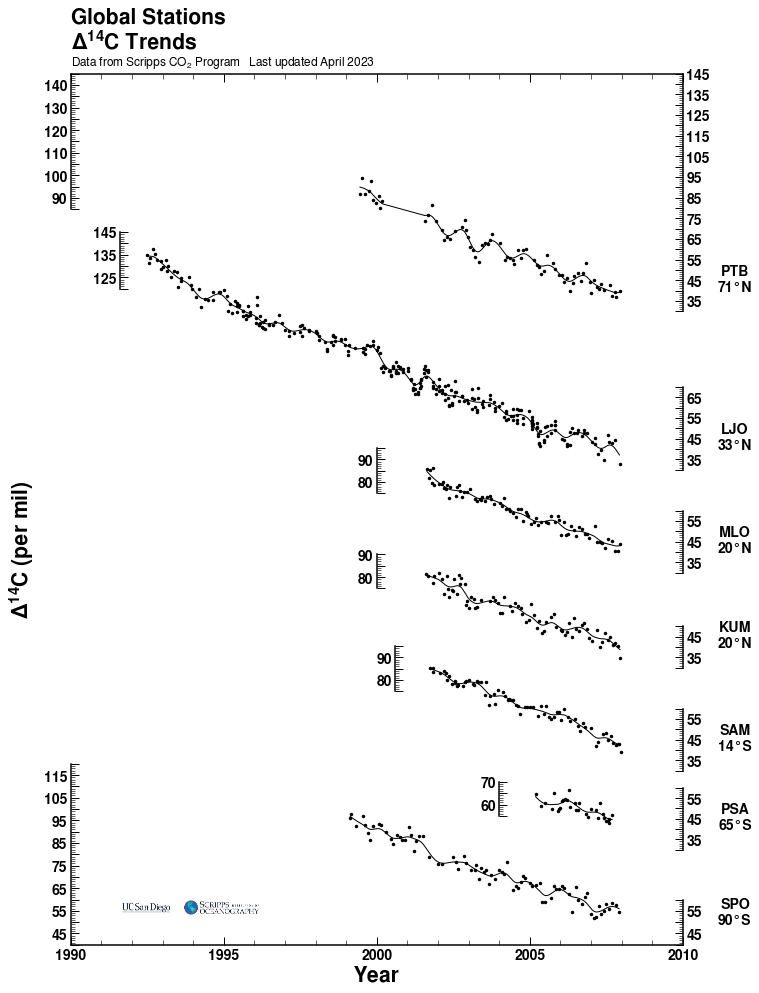

In [64]:
fig = plt.figure()

# ---------------------
# Set figure properties
# ---------------------

ax = fig.add_axes([0,0,1,1])

set_fig_props(ax, fig, xlabel, ylabel)


# Set configuration for each station
# Each station uses their own axes

# stations = ['spo', 'psa', 'sam', 'kum',  'mlo', 'ljo', 'ptb']
# spline_stations = ['spo', 'psa', 'sam', 'kum',  'mlo', 'ljo', 'ptb']

axs = {}
axs_twin = {}
ytick_int = 5

graph_xlim = [xmin, xmax]
graph_ylim = [ymin, ymax]

# count: index of axs and axs_twin lists
# left_ylim: limits of the record's left y axis to show on the plot
# right_ylim: limits of the record's right y axis to show on the plot
# axes_setting: [left, bottom, width, height] of the new Axes
# ylabel_props = [sta_name, sta_degrees, xpos, ypos]

# --------
# Plot SPO
# --------
station = 'spo'
count =  0
left_ylim = [40, 120]
right_ylim = [40, 60]
axes_setting = [0, 0, 1, 0.3]
left_x_pos = 0
ylabel_props = [station.upper(), '90°S', 1.085, 0.2]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)


# --------
# Plot PSA
# --------
station = 'psa'
count = 1
left_ylim = [55, 70]
right_ylim = [30, 60]
axes_setting = [0, 0.12, 1, 0.3]
left_x_pos = 0.7
ylabel_props = [station.upper(), '65°S', 1.085, 0.2]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim,
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot SAM
# --------
station = 'sam'
count =  2
left_ylim = [75, 95]
right_ylim = [30, 60]
axes_setting = [0, 0.22, 1, 0.3]
left_x_pos = 0.53
ylabel_props = [station.upper(), '14°S', 1.085, 0.2]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot KUM
# --------
station = 'kum'
count =  3
left_ylim = [75, 90]
right_ylim = [30, 50]
axes_setting = [0, 0.35, 1, 0.3]
left_x_pos = 0.5
ylabel_props = [station.upper(), '20°N', 1.085, 0.2]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot MLO
# --------
station = 'mlo'
count =  4
left_ylim = [75, 95]
right_ylim = [30, 60]
axes_setting = [0, 0.47, 1, 0.3]
left_x_pos = .5
ylabel_props = [station.upper(), '20°N', 1.085, 0.2]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot LJO
# --------
station = 'ljo'
count =  5
left_ylim = [120, 145]
right_ylim = [30, 70]
axes_setting = [0, 0.6, 1, 0.3]
left_x_pos = 0.08
ylabel_props = [station.upper(), '33°N', 1.085, 0.2]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# --------
# Plot PTB
# --------
station = 'ptb'
count =  6
left_ylim = [85, 145]
right_ylim = [30, 145]
axes_setting = [0, 0.8, 1, 0.3]
left_x_pos = 0
ylabel_props = [station.upper(), '71°N', 1.085, 0.2]

create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim, 
                left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)

# # plot PTB splines

# station = 'ptb1'
# count = 7
# left_ylim = [85, 145]
# right_ylim = [30, 145]
# axes_setting = [0, 0.8, 1, 0.3]
# left_x_pos = 0
# ylabel_props = [station.upper(), '71°N', 1.085, 0.2]

# create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim,
#                 left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)


# station = 'ptb2'
# count = 8
# left_ylim = [85, 145]
# right_ylim = [30, 145]
# axes_setting = [0, 0.8, 1, 0.3]
# left_x_pos = 0
# ylabel_props = [station.upper(), '71°N', 1.085, 0.2]

# create_sub_plot(count, station, fig, axs, axs_twin, axes_setting, graph_xlim, graph_ylim,
#                 left_ylim, right_ylim, ytick_int, left_x_pos, ylabel_props)


# --------------------------
# Congigure x axis of figure
# --------------------------

configure_fig_xaxis(axs, xmin, xmax)


# ---------------
# Add plot titles
# ---------------   
add_plot_title(ax, title1, title2, title3)

# --------------------
# Add SIO logo to plot
# --------------------
xpos = 0.07
ypos = 0.03

add_sio_logo(fig, logo_file, xpos, ypos)


# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()

save_plot_for_website(fig)


plt.show()